In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import copy
%matplotlib notebook

In [2]:
from neurodiffeq import diff      # the differentiation operation
from neurodiffeq.ode import solve # the ANN-based solver
from neurodiffeq.conditions import IVP   # the initial condition
from neurodiffeq.networks import FCNN    # fully-connect neural network
from neurodiffeq.networks import SinActv # sin activation
from neurodiffeq.monitors import Monitor1D
from neurodiffeq.solvers import Solver1D
from neurodiffeq.callbacks import MonitorCallback
from neurodiffeq.callbacks import WeightCallback
from neurodiffeq.callbacks import WeightCallback1,WeightCallback2
from neurodiffeq.callbacks import PeriodLocal
import copy

/Users/shaan/anaconda3/envs/main/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### does pretraining with a kth order method work?

In [3]:
MAX_EPOCHS = 3000
BURNIN = 0
SUB_RATE = 1
T_EVAL = torch.linspace(-2,2,100)


In [4]:
kth = lambda u, t: [diff(u, t) + u+u**2 +u**3 + u**4 + u**5 +1] # specify the ODE
init_val_kth = [IVP(t_0=0.0, u_0=.5)]       # specify the initial conditon
solver_kth1 = Solver1D(
    ode_system=kth,
    conditions=init_val_kth,
    t_min=-2,
    t_max=2.0,
)
solver_kth1.fit(max_epochs=MAX_EPOCHS)
pre_net = copy.deepcopy(solver_kth1.get_internals()['best_nets'])

kth = lambda u, t: [diff(u, t) - u-u**2 -u**3 - u**4 - u**5 +1] # specify the ODE
init_val_kth = [IVP(t_0=0.0, u_0=.5)]       # specify the initial conditon
solver_kth2 = Solver1D(
    ode_system=kth,
    conditions=init_val_kth,
    t_min=-2,
    t_max=2.0,
)
solver_kth2.fit(max_epochs=MAX_EPOCHS)
pre_net1 = copy.deepcopy(solver_kth2.get_internals()['best_nets'])

kth = lambda u, t: [diff(u, t) - u+u**2 -u**3 + u**4 - u**5 +1] # specify the ODE
init_val_kth = [IVP(t_0=0.0, u_0=.5)]       # specify the initial conditon
solver_kth3 = Solver1D(
    ode_system=kth,
    conditions=init_val_kth,
    t_min=-2,
    t_max=2.0,
)
solver_kth3.fit(max_epochs=MAX_EPOCHS)
pre_net2 = copy.deepcopy(solver_kth3.get_internals()['best_nets'])


In [11]:
eps = np.arange(1,1+MAX_EPOCHS,dtype=int)[BURNIN::SUB_RATE]
MX_EPS = 100

test_sigmoid = lambda u, t: [diff(u, t) -u +u**2] # specify the ODE
init_val_sig = [IVP(t_0=0.0, u_0=.5)]     # specify the initial conditon
solver_sigmoid_test11 = Solver1D(
    ode_system=test_sigmoid,
    conditions=init_val_sig,
    t_min=-2,
    t_max=2.0,
    nets = pre_net
)
solver_sigmoid_test11.fit(max_epochs=MX_EPS)



test_sigmoid = lambda u, t: [diff(u, t) -u +u**2] # specify the ODE
init_val_sig = [IVP(t_0=0.0, u_0=.5)]     # specify the initial conditon
solver_sigmoid_test12 = Solver1D(
    ode_system=test_sigmoid,
    conditions=init_val_sig,
    t_min=-2,
    t_max=2.0,
    nets = pre_net1
)
solver_sigmoid_test12.fit(max_epochs=MX_EPS)



test_sigmoid = lambda u, t: [diff(u, t) -u +u**2] # specify the ODE
init_val_sig = [IVP(t_0=0.0, u_0=.5)]     # specify the initial conditon
solver_sigmoid_test13 = Solver1D(
    ode_system=test_sigmoid,
    conditions=init_val_sig,
    t_min=-2,
    t_max=2.0,
    nets = pre_net2
)
solver_sigmoid_test13.fit(max_epochs=MX_EPS)

test_sigmoid = lambda u, t: [diff(u, t) -u +u**2] # specify the ODE
init_val_sig = [IVP(t_0=0.0, u_0=.5)]     # specify the initial conditon
solver_sigmoid_test2 = Solver1D(
    ode_system=test_sigmoid,
    conditions=init_val_sig,
    t_min=-2,
    t_max=2.0,
)
solver_sigmoid_test2.fit(max_epochs=MX_EPS)

In [12]:
%matplotlib inline

(4.012256470390763e-05,
 3.3205140594861455e-05,
 4.181413832815154e-06,
 7.145035613726897e-05)

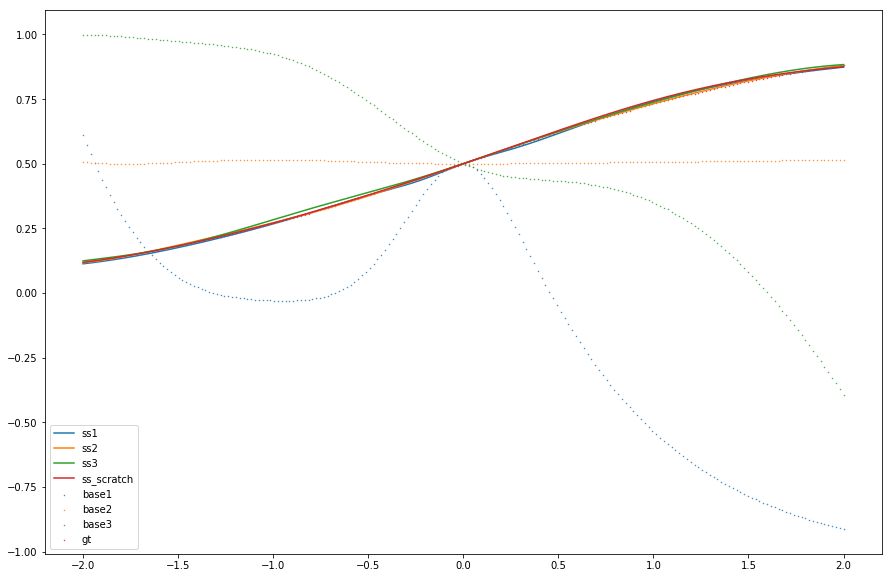

In [13]:
plt.figure(figsize=(15,10))
ts = torch.linspace(-2,2,200).reshape(-1,1)
ss01 = solver_kth1.get_solution()(ts,to_numpy=True)
ss02 = solver_kth2.get_solution()(ts,to_numpy=True)
ss03 = solver_kth3.get_solution()(ts,to_numpy=True)
ss1 = solver_sigmoid_test11.get_solution()(ts,to_numpy=True)
ss2 = solver_sigmoid_test12.get_solution()(ts,to_numpy=True)
ss3 = solver_sigmoid_test13.get_solution()(ts,to_numpy=True)
ss_scratch = solver_sigmoid_test2.get_solution()(ts,to_numpy=True)
ss_true = torch.sigmoid(ts).detach().numpy()
ts_np = ts.detach().numpy()
plt.scatter(ts_np,ss01,label='base1',s=0.2)
plt.scatter(ts_np,ss02,label='base2',s=0.2)
plt.scatter(ts_np,ss03,label='base3',s=0.2)
plt.plot(ts_np,ss1,label='ss1')
plt.plot(ts_np,ss2,label='ss2')
plt.plot(ts_np,ss3,label='ss3')
plt.plot(ts_np,ss_scratch,label='ss_scratch')
plt.scatter(ts_np,ss_true,label='gt',s=0.2)
plt.legend()
((ss_scratch-torch.sigmoid(ts).detach().numpy())**2).mean(),((ss1-torch.sigmoid(ts).detach().numpy())**2).mean(),((ss2-torch.sigmoid(ts).detach().numpy())**2).mean(),((ss3-torch.sigmoid(ts).detach().numpy())**2).mean()

In [ ]:
def mse(u, t):
        true_u = torch.cos(t)
        return torch.mean( (u - true_u)**2 )


In [20]:
equations = ['exp1','tanh1','psig1','testsig1','testsig21']
eps = [MAX_EPOCHS]


In [21]:
param_a = np.load(f'data/{equations[-4]}/{ep}.npy')
param_b = np.load(f'data/{equations[-1]}/{ep}.npy')
%matplotlib inline
plt.figure()
plt.hist(param_a,density=True)
plt.hist(param_b,alpha=0.3,density=True);
plt.hist(-param_b,alpha=0.3,density=True);

plt.yscale('log')

NameError: name 'ep' is not defined

In [10]:
meth_dex = 0
wdots= np.zeros((len(eps),len(equations)))
for meth_dex in range(len(equations)):
    for ep_index,ep in enumerate(eps):
        param_a = np.load(f'data/{equations[meth_dex]}/{ep}.npy')
        param_b = np.load(f'data/{equations[-1]}/{ep}.npy')
        wdots[ep_index,meth_dex]=np.dot(param_a,param_b)
print(wdots)


[[-1.02879319 -1.94017129  1.68018525 -0.40537968 33.58061686]]


The solution at the 100th epoch can be used to compare - but this would really be a problem with cosine and sine.. we hope that the weights learn an underlying representation useful for transfer.

In [65]:
((vec_exp - vec_sigtest)**2).mean()

0.04263164435521143

In [66]:
((vec_tanh - vec_sigtest)**2).mean()

0.015944930785674355

In [67]:
((vec_sig1 - vec_sigtest)**2).mean()

1.0368649273154875e-05

In [73]:
((vec_sigtest2 - vec_sigtest)**2).mean()

0.017895323901821837

In [34]:
# MAX_EPOCHS = 3000
BURNIN = 50
equations = ['exp1','tanh1','psig1','testsig1','testsig21']
import os
%matplotlib inline
eps = [i for i in range(BURNIN,MAX_EPOCHS) if (i%SUB_RATE==0)]

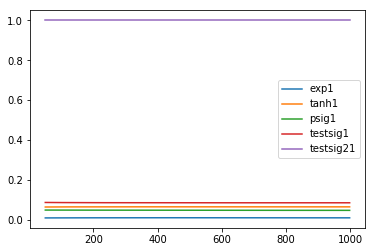

In [35]:
meth_dex = 0
wdots= np.zeros((len(eps),len(equations)))
for meth_dex in range(len(equations)):
    for ep_index,ep in enumerate(eps):
        
        param_a = np.load(f'data/{equations[meth_dex]}/{ep}.npy')
#         print(param_a)
        param_b = np.load(f'data/{equations[-1]}/{ep}.npy')
        wdots[ep_index,meth_dex]=np.dot(param_a,param_b)/(np.linalg.norm(param_a)*np.linalg.norm(param_b))
        
plt.figure()
for i in range(len(equations)):
    plt.plot(eps,np.cumsum(np.abs(wdots),0)[:,i]/np.cumsum(np.abs(wdots),0)[:,-1],label=equations[i])
plt.legend()

##### Ranked Weights

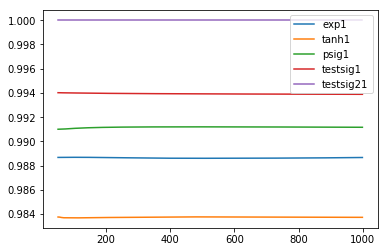

In [36]:
meth_dex = 0
wdots= np.zeros((len(eps),len(equations)))
for meth_dex in range(len(equations)):
    for ep_index,ep in enumerate(eps):
        param_a = np.load(f'data/{equations[meth_dex]}/{ep}.npy')
        param_b = np.load(f'data/{equations[-1]}/{ep}.npy')
        wdots[ep_index,meth_dex]=np.dot(np.sort(param_a),np.sort(param_b))/(np.linalg.norm(param_a)*np.linalg.norm(param_b))
        
plt.figure()
for i in range(len(equations)):
    plt.plot(eps,np.cumsum(np.abs(wdots),0)[:,i]/np.cumsum(np.abs(wdots),0)[:,-1],label=equations[i])
plt.legend()
# plt.yscale('log')
# plt.xlim([2000,3000])
# plt.ylim([300,500])

using the weights or dy/dw isn't informative. we can try to use dy/dx but that is equivlent to comparing the solution. We could try a joint qp metric.

#### 

In [36]:
MAX_EPOCHS = 3000
BURNIN = 0
SUB_RATE = 1
T_EVAL = torch.linspace(0.5,2,1)

eps = np.arange(1,1+MAX_EPOCHS,dtype=int)[BURNIN::SUB_RATE]

mdl_weight_collector = []


cb = PeriodLocal(period=SUB_RATE)
act_cb = WeightCallback1('exp1',T_EVAL)
cb.set_action_callback(act_cb)
exponential = lambda u, t: [diff(u, t)-u+u**2] # specify the ODE
init_val_ex = [IVP(t_0=0.0, u_0=0.5)]       # specify the initial conditon
solver_exp = Solver1D(
    ode_system=exponential,
    conditions=init_val_ex,
    t_min=-2.,
    t_max=2.0,
)
solver_exp.fit(max_epochs=MAX_EPOCHS,callbacks=[cb])



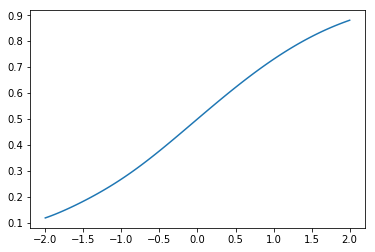

In [38]:
ts = torch.linspace(-2,2,100)
sols = solver_exp.get_solution()(ts,to_numpy=True)
plt.plot(ts.detach().numpy(),sols)

In [14]:
for param in (solver_exp.nets[0]).parameters():
    print(param)


Parameter containing:
tensor([[-0.6234],
        [-0.4825],
        [-0.4797],
        [ 0.7175],
        [ 0.4618],
        [-0.5874],
        [ 0.4158],
        [-0.5045],
        [ 0.2694],
        [ 0.4619],
        [ 0.4420],
        [-0.7583],
        [-0.0689],
        [-0.1621],
        [ 0.7429],
        [ 0.3287],
        [ 0.0019],
        [ 0.0156],
        [-0.4506],
        [-0.5204],
        [ 0.1074],
        [-0.0353],
        [-0.0489],
        [-0.2013],
        [ 0.8048],
        [-0.5709],
        [ 0.5071],
        [ 0.2266],
        [-0.5517],
        [ 0.0435],
        [-0.1881],
        [ 0.7034]], requires_grad=True)
Parameter containing:
tensor([-0.0656,  0.9533, -0.4622, -0.9906,  0.6088,  0.4050,  0.4968,  0.5733,
         0.2727, -0.1756, -0.4755,  0.7543, -0.3404,  0.6988, -0.8310, -0.7107,
         0.1254, -0.6880,  0.5160, -0.1021,  0.5461, -0.9538, -0.3895,  0.5421,
        -0.1903,  0.2782,  0.1903, -0.3090, -0.5044,  0.8546, -0.2537,  0.8195],
      